# Валидная разметка медицинских изображений
Импорт системных модулей:

In [1]:
import os
from glob import glob

Импорт дополнительных библиотек:

In [2]:
%matplotlib inline

import numpy as np
import pydicom
import matplotlib
import sklearn
import skimage
plt = matplotlib.pyplot

### Генерация файла *requirements.txt*

In [3]:
status =  False 
if status == True:
    req_file = open('requirements.txt', 'w')
    req_file.write('numpy ' + np.__version__ + '\n')
    req_file.write('pydicom ' + pydicom.__version__ + '\n')
    req_file.write('matplotlib ' + matplotlib.__version__ + '\n')
    req_file.write('sklearn ' + sklearn.__version__ + '\n')
    req_file.write('skimage ' + skimage.__version__ + '\n')
    req_file.close()

## Загрузка данных

### Настройка путей для загрузки и записи новых данных:

In [4]:
data_path = 'ct_locator_sample'
output_path = 'annotated_images/'
dicom_file_name = glob(data_path + '/*')

print ('Total of %d DICOM images.' % len(dicom_file_name))

Total of 1149 DICOM images.


# Введение
Данная работа заключается в том, чтобы разметить сники с локалайзера компьютерного томографа по следующим отделам:
* Голова
* Шея
* Грудная клетка 
* Брюшная полость
* Малый таз

Далее эту разметкe следует добавить в виде наложений (**overlays**) к соответствующему `dicom`-файлу. 

***
## Вспомогательные функции#

### Функция для отображения Pixel Array:

In [5]:
def show_pixel_array(file, title):
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    ax.set_title(title)
    ax.imshow(file, cmap='gray')
    ax.axis('on')
    
    plt.show()

### Функция для загрузки dicom-файлов:

In [6]:
def load_images(path):
    images = [pydicom.read_file(path + '/' + i) for i in os.listdir(path)]
    
    return images

### Функция для получения вокселов с соответствующего снимка:

In [7]:
def get_voxel_HU(image):
    image1 = np.stack(image.pixel_array)
    image1 = image1.astype(np.int16)
    image1[image1 == -2000] = 0
    
    intercept = image.RescaleIntercept
    slope = image.RescaleSlope
    
    if slope != 1:
        image1 = slope * image1.astype(np.float64)
        image1 = image1.astype(np.int16)
        
    image1 += np.int16(intercept)
    
    return np.array(image1, dtype=np.int16)

### Функция стандартизации изображения:

In [8]:
def standardize_voxel_values(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    return img

def show_standardize_image(img, title = 'Стандартизованное изображение'):
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    ax.set_title(title)
    ax.imshow(img, cmap='gray')
    ax.axis('on')

### Функция наложения маски:

In [9]:
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

def set_mask(img, ero_contr, dil_contr):
    middle = img[0:100,0:100] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    img[img==max]=mean
    img[img==min]=mean
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = 0 # Устанавливаем такое ограничение, для того, чтобы отфильтровать стол
    thresh_img = np.where(img<threshold,1.0,0.0)
    
    for i in range(len(thresh_img)):
        for j in range(len(thresh_img[i])):
            if thresh_img[i][j] == 1:
                thresh_img[i][j] = 0
            else:
                thresh_img[i][j] = 1
    
    eroded = morphology.erosion(thresh_img,np.ones([ero_contr,ero_contr]))
    dilation = morphology.dilation(eroded,np.ones([dil_contr,dil_contr]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    
    return labels

def show_mask(labels):
    fig, ax = plt.subplots(1, 1, figsize=[10, 10])
    ax.set_title('Полученная маска')
    ax.imshow(labels, cmap='gray')
    ax.axis('on')

### Функция применения маски:

In [10]:
def apply_mask(img, bound_begin, bound_end, ero_contr, dil_contr):
    mask = set_mask(img, ero_contr, dil_contr)
    mask[:bound_begin, :] = 0
    mask[bound_end:, :] = 0
    
    return mask

### Функция добавления наложения:

In [11]:
from pydicom.datadict import DicomDictionary, keyword_dict
from pydicom.dataset import Dataset
from pydicom.pixel_data_handlers.numpy_handler import pack_bits

def add_overlay(image, area, array):
    groups = {
        'Head': 0x6000,
        'Neck': 0x6002,
        'Chest': 0x6004,
        'Abdomen': 0x6006,
        'Pelvis': 0x6008,
    }
    
    string = area + ': Overlay Rows'
    
    new_dict_items = {
        (groups[area], 0x0010): ('US', '1', string, '', 'OverlayRows'),
        (groups[area], 0x0011): ('US', '1', area + ": Overlay Columns", '', 'OverlayColumns'),
        (groups[area], 0x0015): ('IS', '1', area + ": Number of Frames in Overlay", '', 'NumberFrames'),
        (groups[area], 0x0022): ('LO', '1', area + ": Overlay Description ", '', 'OverlayDescription'),
        (groups[area], 0x0040): ('CS', '1', area + ": Overlay Type", '', 'OverlayType'),
        (groups[area], 0x0050): ('SS', '2', area + ": Overlay Origin", '', 'OverlayOrigin'),
        (groups[area], 0x0051): ('US', '1', area + ": Image Frame Origin ", '', 'ImageFrameOrigin'),
        (groups[area], 0x0100): ('US', '1', area + ": Overlay Bits Allocated", '', 'OverlayBitsAllocated'),
        (groups[area], 0x0102): ('US', '1', area + ": Overlay Bit Position", '', 'OverlayBitPosition'),
        (groups[area], 0x3000): ('OW', '1', area + ": Overlay Data", '', 'OverlayData'),
    }
    
    DicomDictionary.update(new_dict_items)
    
    new_names_dict = dict([(val[4], tag) for tag, val in new_dict_items.items()])
    keyword_dict.update(new_names_dict)
    
    row_count, col_count = array.shape
    
    image.OverlayRows = row_count
    image.OverlayColumns = col_count
    image.NumberFrames = 1
    image.OverlayDescription = area
    image.OverlayType = 'G'
    image.OverlayOrigin = [1, 1]
    image.ImageFrameOrigin = 1
    image.OverlayBitsAllocated = 1
    image.OverlayBitPosition = 0
    
    array_new = np.reshape(array, array.size)
    packed_bytes = pack_bits(array_new)
    
    # Pad the value if odd-length
    if len(packed_bytes) % 2:
        packed_bytes += b'\x00'
    
    image.OverlayData = packed_bytes
    image[groups[area], 0x3000].VR = 'OW' # Разрешим неопределенность в VR
    
    #image.save_as(saved_name)
    return image

***

# Работа с Overlay Data

**Overlays** в DICOM присутствуют в так называемой повторяющейся группе (Repeating Group), где номер группы тегов элемента определяется по диапазону, а не по определенному значению. Например, номер группы тега для (60xx, 3000) оверлейных данных может быть 6000, 6002 или любое четное значение до 601E. Это позволяет в набор данных включать несколько **overlays**, где связанные элементы для каждого наложения используют один и тот же номер группы. Из-за этого единственный способ получить доступ к определенному элементу из оверлея - использовать метод `Dataset [group, elem]`.

Рассмотрим снимок с **overlays** c вязтый с git-репозитория [pydicom](https://github.com/pydicom/pydicom/blob/master/pydicom/data/test_files/MR-SIEMENS-DICOM-WithOverlays.dcm) от [Dicom in Python](https://github.com/pydicom) на GitHub:

In [12]:
data_set = pydicom.dcmread('pydicom_tutorial/MR-SIEMENS-DICOM-WithOverlays.dcm')
element = data_set[0x6000, 0x3000]
print(element)

(6000, 3000) Overlay Data                        OW: Array of 29282 elements


По умолчанию **Pydicom** ничего не делает с **Overlay Data**, кроме чтения в необработанных байтах:

In [13]:
element.value[:10] 

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

Чтобы распаковать и получить **Overlay Data** в более полезной форме, следует использовать метод `overlay_array()` для возврата `numpy.ndarray`. Чтобы использовать его, нкжно просто передать номер группы интересующих элементов **Overlay Data**: `data_set.overlay_array(0x6000)`.

При работе с **Overlay Data** нужно помнить, что верхний левый угол **Overlay** не обязательно должен совпадать с верхним левым краем соответствующих данных пикселей. Фактическое смещение между ними можно определить из `(60xx, 0050) Overlay Origin`, где значение [1, 1] указывает, что верхние левые пиксели выровнены, а значение [0, 0] указывает, что оверлейные пиксели начинаются на одну строку выше и на одну строку левее от пикселей изображения.

*NumPy* может использоваться для изменения пикселей, но если изменения должны быть сохранены, они должны быть упакованы битами и записаны обратно в правильный элемент:

In [14]:
arr = data_set.overlay_array(0x6000)

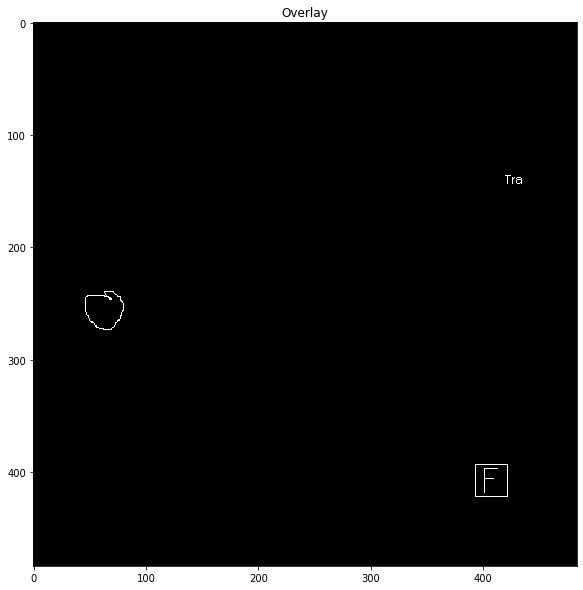

In [15]:
show_pixel_array(arr, 'Overlay')

Дабавим новую линию на наложение:

In [16]:
arr[100, :] = 1

In [17]:
arr_new = np.reshape(arr, arr.size)

In [18]:
# Pack the data
from pydicom.pixel_data_handlers.numpy_handler import pack_bits
packed_bytes = pack_bits(arr_new)

# Pad the value if odd-length
if len(packed_bytes) % 2:
    packed_bytes += b'\x00'

# Update the element value
data_set[0x6000, 0x3000].value = packed_bytes
data_set.save_as('pydicom_tutorial/temp.dcm')

Загрузим только что созранненый снимок и проверим **overlay**:

In [19]:
ds_new = pydicom.dcmread('pydicom_tutorial/temp.dcm')
element_new = ds_new[0x6000, 0x3000]
print(element_new)

(6000, 3000) Overlay Data                        OW: Array of 29282 elements


In [20]:
arr_new = ds_new.overlay_array(0x6000)

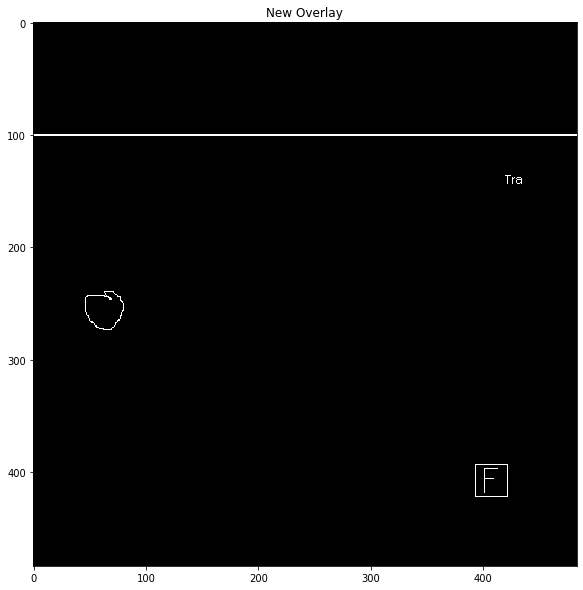

In [21]:
show_pixel_array(arr_new, 'New Overlay')

***
# Пример разметки изображений
Загрузим изображения, которые хотим разметить:

In [22]:
images = load_images(data_path)

Выберем одно, например, первое:

In [23]:
image = images[0]

Посмотрим на его методанные:

In [24]:
image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER', 'ES']
(0008, 0012) Instance Creation Date              DA: '19800101'
(0008, 0013) Instance Creation Time              TM: '555555'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.7.1.1.5096.1492017150.4
(0008, 0020) Study Date                          DA: '19800101'
(0008, 0022) Acquisition Date                    DA: '19800101'
(0008, 0023) Content Date                        DA: '19800101'
(0008, 002a) Acquisition DateTime                DT: ''
(0008, 0030) Study Time                          TM: '555555'
(0008, 0032) Acquisition Time                    TM: '555555'
(0008, 0033) Content Time                        TM: '555555'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0

Получим его стандартизованный вид:

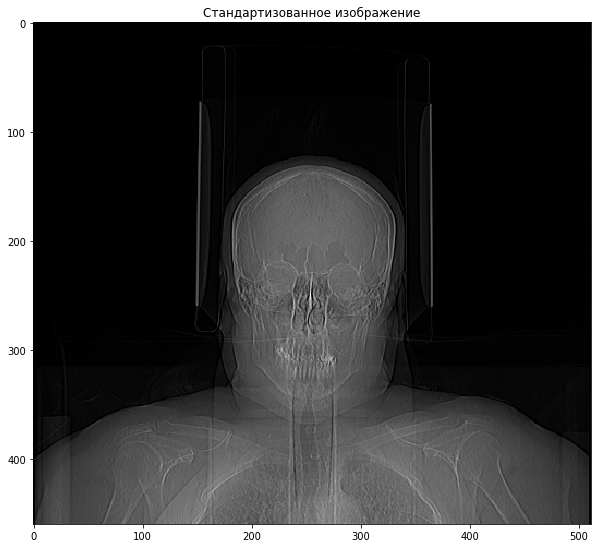

In [25]:
image_vox = get_voxel_HU(image)
image_std = standardize_voxel_values(image_vox)
show_standardize_image(image_std)

In [26]:
image_std.shape

(460, 512)

На данный снимок попало два, интересующих нас отдела, - это **голова**, **шея** и верхняя часть **гружной клетки**. 

Следовательно выделим эти части:

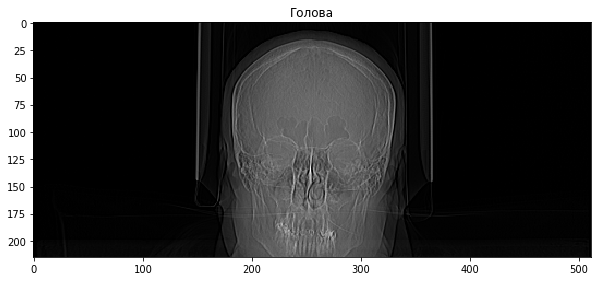

In [27]:
head = image_std[115:330, :]
show_standardize_image(head, 'Голова')

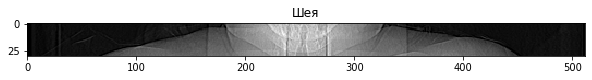

In [28]:
neck = image_std[330:360, :]
show_standardize_image(neck, 'Шея')

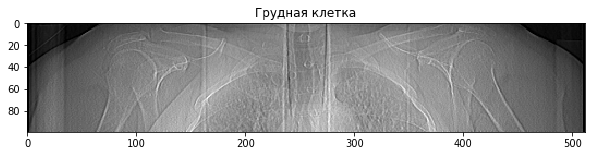

In [29]:
chest = image_std[360:460, :]
show_standardize_image(chest, 'Грудная клетка')

Наложим маски на выбранные части:

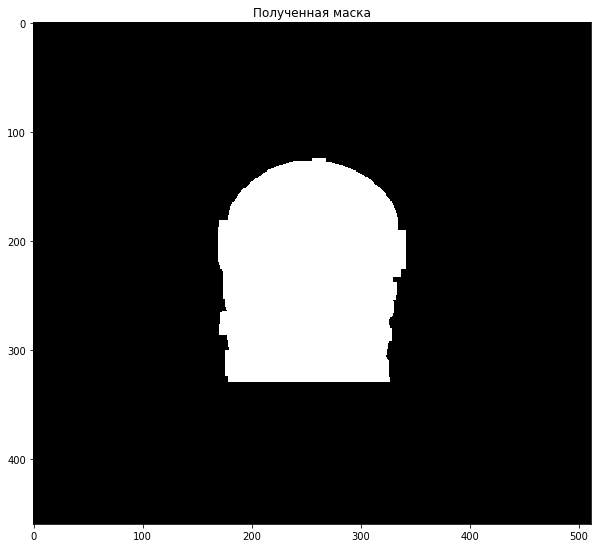

In [30]:
head_mask = apply_mask(image_std,115, 330, 4, 10)
show_mask(head_mask)

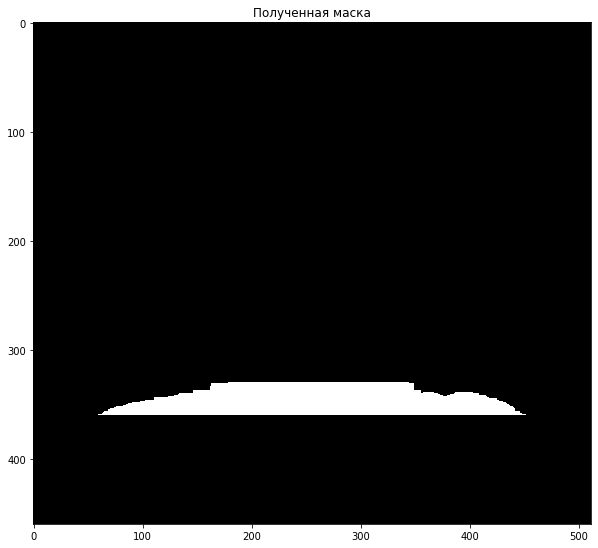

In [31]:
neck_mask = apply_mask(image_std,330, 360, 4, 10)
show_mask(neck_mask)

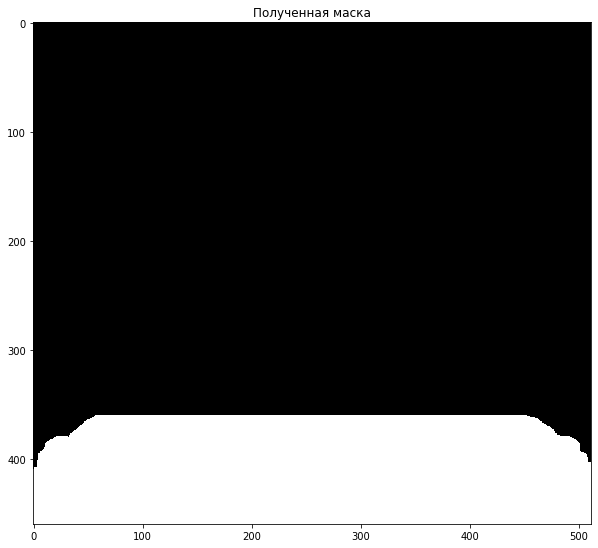

In [32]:
chest_mask = apply_mask(image_std,360, 460, 4, 10)
show_mask(chest_mask)

In [33]:
image = add_overlay(image, 'Head', head_mask)
image = add_overlay(image, 'Neck', neck_mask)
image = add_overlay(image, 'Chest', chest_mask)

Посмотрим на метаданные измененного изображения и убедимся в том, что наложения успешно добавлены:

In [34]:
image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER', 'ES']
(0008, 0012) Instance Creation Date              DA: '19800101'
(0008, 0013) Instance Creation Time              TM: '555555'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.7.1.1.5096.1492017150.4
(0008, 0020) Study Date                          DA: '19800101'
(0008, 0022) Acquisition Date                    DA: '19800101'
(0008, 0023) Content Date                        DA: '19800101'
(0008, 002a) Acquisition DateTime                DT: ''
(0008, 0030) Study Time                          TM: '555555'
(0008, 0032) Acquisition Time                    TM: '555555'
(0008, 0033) Content Time                        TM: '555555'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CT'
(0

Сохраним размеченное изображение:

In [35]:
image.save_as(output_path + 'image_1.dcm')